# ROC curve and AUC

This notebook uses the chest X-ray dataset that can be found in: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia 

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,TensorBoard, EarlyStopping
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, \
            Dense, Activation, Flatten, Dropout, Input

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd


## Settings

In [3]:
log_and_model_path = 'd:/vcpi/DL06/ROC'
data_path = 'd:/vcpi/chestXRay'

train_online = False

In [4]:

BATCH_SIZE = 32
IMAGE_SIZE = 256

## Aux functions for display purposes

In [5]:
def show_batch(cols, image_batch, label_batch):

    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['simple', 'new layers']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()


def show_data(s1,l1, s2,l2, labels):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1-00, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()


    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    
def show_confusion_matrix(model, dataset):
   
    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):  
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)  
        
        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]
        
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

    df_cm = pd.DataFrame(conf_mat.numpy(), range(2), range(2))
    plt.figure(figsize=(5,3))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()

    res_correct = {0:0, 1:0}
    res_incorrect = {0:0, 1:0}
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):

        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))

In [6]:
classNames = np.array(os.listdir(f'{data_path}/train'))


def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMAGE_SIZE,IMAGE_SIZE])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

## Load dataset

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_listset = tf.data.Dataset.list_files(f'{data_path}/train/*/*.jpeg')
train_set = train_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

test_listset = tf.data.Dataset.list_files(f'{data_path}/test/*/*.jpeg')
test_set = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [8]:
for image, label in train_set.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

dataset_length = train_set.cardinality().numpy()
print(dataset_length)


Image shape:  (256, 256, 3)
Label:  [ True False]
5232


In [9]:
train_set = train_set.cache()
train_set = train_set.shuffle(buffer_size=2048)
train_set = train_set.batch(batch_size = BATCH_SIZE)
train_set = train_set.prefetch(buffer_size = AUTOTUNE)

In [10]:
test_set = test_set.batch(batch_size = BATCH_SIZE)

## Model

This model is similar to the one used in the previous lesson

In [11]:
def model_III(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(128, (5, 5), 
                     input_shape=(imgSize, imgSize, channels)
                     ))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    
    model.add(Conv2D(128, (5, 5) )) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (5, 5) ) )   
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (5, 5) ) )   
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (5, 5) ) )   
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

In [12]:
modelV3 = model_III(2, IMAGE_SIZE, 3)

print(modelV3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 128)     9728      
                                                                 
 batch_normalization (BatchN  (None, 252, 252, 128)    512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 252, 252, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 248, 248, 128)     409728    
                                                                 
 batch_normalization_1 (Batc  (None, 248, 248, 128)    512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 248, 248, 128)     0

c:\Users\anton\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Prepare and train the model

In [13]:
def prepareCallbacks(path):

    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath= file_path, 
                                monitor = 'val_accuracy',
                                verbose=1, 
                                save_weights_only=True,
                                save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)

    return file_path, [checkpointer, earlyStopper, tbCallBack]



In [14]:
print(train_set)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))>


In [15]:
file_pathV4, callbacksV4 = prepareCallbacks('V4')


dataset_len = train_set.cardinality().numpy()
print(dataset_len)
train = train_set.take(int(164*0.8))
val = train_set.skip(int(164*0.8))


if (train_online):
    historyV4 = modelV3.fit(train,
          epochs=50, 
          validation_data = val, 
          callbacks=callbacksV4)

164


## Evaluate

In [16]:
modelV3.load_weights(file_pathV4)

evalV3 = modelV3.evaluate(test_set, verbose=2)
print(evalV3)
valV3 = modelV3.evaluate(val, verbose=2)

20/20 - 10s - loss: 1.1526 - accuracy: 0.7564 - 10s/epoch - 513ms/step
[1.1525996923446655, 0.7564102411270142]
33/33 - 48s - loss: 0.0152 - accuracy: 0.9971 - 48s/epoch - 1s/step


Note that there is a huge difference between test and validation accuracies. To properly build a validation set we would have to include all the x-rays for a set of persons. As is, the validation set is totally random and therefore it contains X-rays that belong to sequences found in the training set. This makes the validation set useless as a way to control where to stop training.

There is information regarding the person to which the X-ray belongs to in the class for pneumonia, but there is no such information in the normal class.

Note also that if we just predicted all to be pneumonia cases (the predominant class) we would get 62.5% accuracy.

## Display the Confusion Matrix

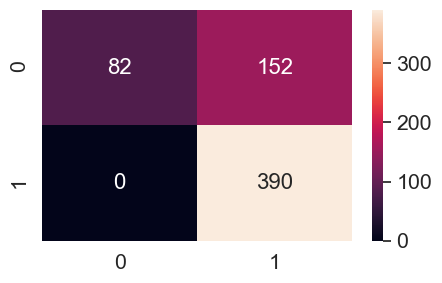

class:  0  total images:  234  % correct:  0.3504273504273504
class:  1  total images:  390  % correct:  1.0


In [17]:
show_confusion_matrix(modelV3, test_set)

Confusion matrix with labels

Note: if you train the model again you may obtain different numbers.

|                  | Predicted Normal | Predicted Pneumonia |
|------------------|------------------|---------------------|
| Actual Normal    | 82               | 152                 |
| Actual Pneumonia | 0                | 390                 |

Confusion Matrix Interpretation

|                  | Predicted Normal | Predicted Pneumonia |
|------------------|------------------|---------------------|
| Actual Normal    | True Negatives   | False Positives     |
| Actual Pneumonia | False Negatives  | True Positives      |




The ROC curve (receiver operating characteristic curve) allows to graphically show the performance of a model at different classification thresholds. The graph plots two parameters:

True Positive Rate $TPR = \Large \frac{TP }{TP + FN}$

False Positive Rate $FPR = \Large \frac{FP }{FP + TN}$

In the above Confusion Matrix we have

$TPR = {\Large \frac{390 }{0 + 390}} = 1.0$

$FPR = {\Large \frac{152 }{82 + 152}} = 0.35$

These values were obtained with a classification threshold of 0.5

In [18]:
preds = modelV3.predict(test_set)

20/20 [==============================] - 3s 151ms/step


In [19]:
preds[:5]

array([[6.1680824e-01, 3.8319173e-01],
       [2.0085454e-03, 9.9799144e-01],
       [6.5033499e-05, 9.9993491e-01],
       [1.0515010e-07, 9.9999988e-01],
       [4.6707201e-04, 9.9953294e-01]], dtype=float32)

In [20]:
labels = []
pred = []
for image, label in test_set.take(-1):
  pred.extend(modelV3.predict(image, verbose = 0))
  labels.extend(label.numpy())


Get just the preds and labels for the pneumonia class

In [21]:
p = [x[1] for x in pred]
l = [x[1] for x in labels]

print(len(p))

624


Separate preds into two different sets: with and without pneumonia

In [22]:
normal = [p[i] for i in range(len(l)) if l[i] == 0]
pneu = [p[i] for i in range(len(l)) if l[i] == 1]

Plot the histograms of the preds for each class

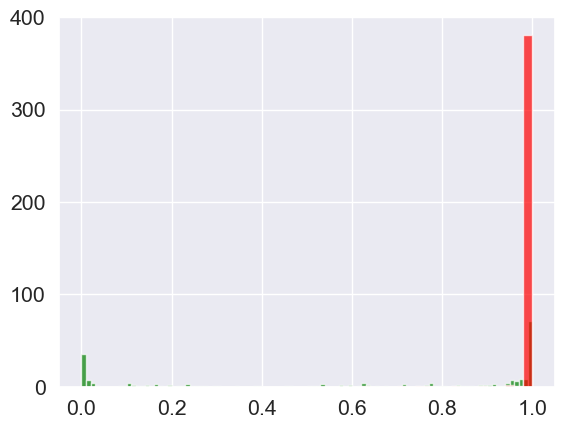

In [23]:
plt.hist(normal, 100, density = 0, color ='green', alpha = 0.7)
plt.hist(pneu, 50, density = 0, color ='red', alpha = 0.7, range = (0,1))
plt.show()

In [24]:
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

bin = [0 if x < 0.1 else 1  for x in p]

accuracy_score(l, bin)

0.7051282051282052

In [25]:
conf_mat = tf.math.confusion_matrix(l, bin)
conf_mat


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 50, 184],
       [  0, 390]])>

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(l, p)

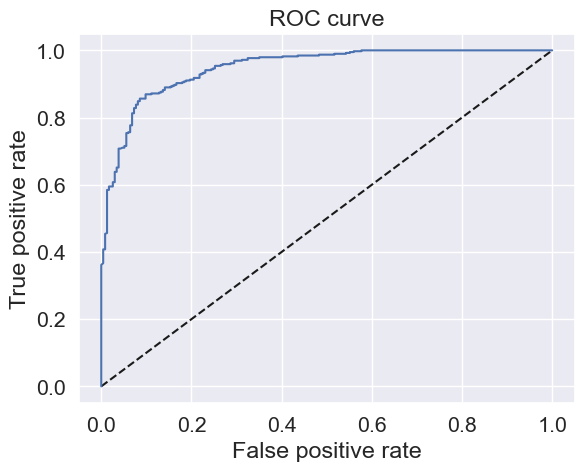

In [27]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.show()
# Zoom in view of the upper left corner.


In [28]:
from sklearn.metrics import auc
auc_model = auc(fpr, tpr)

print(auc_model)

0.9483125136971291
